### Install all requirements

In [ ]:
%pip install datasets torch transformers huggingface --quiet

In [ ]:
%pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118

### Import Section
Imports necessary libraries and modules for file handling, JSON manipulation, deep learning, dataset handling, tokenization, model loading, and training.

In [2]:
import os
import json
import torch
import datasets
from typing import List
from functools import partial
from transformers import (
    AutoTokenizer,
    AutoModelForCausalLM,
    AutoModelForSeq2SeqLM,
    TrainingArguments,
    Trainer
  )
from datasets import load_dataset, DatasetDict

### Load the model and tokenizer
Initializes the tokenizer and model for "google/flan-t5-large" and sets up a directory to save the fine-tuned model.

In [3]:
model_name = "google/flan-t5-large"
tokenizer = AutoTokenizer.from_pretrained(model_name)
save_dir = f'models/fine_tuned_models/RCTI_flan_t5_large_2e_qa'

base_model = AutoModelForSeq2SeqLM.from_pretrained(
    model_name,
    device_map="cuda",
)

### Dataset preparation method
The following section defines a method "tokenize_the_data()" to tokenize the dataset, ensuring that questions and answers are properly formatted for the model. It also defines another method "prepare_dataset()" that prepares and tokenizes the dataset using the earlier method, splits it into training and testing sets, and adds labels for training.

In [4]:
def tokenize_the_data(examples,
                      tokenizer,
                      tokenizer_max_length: int,
                      column_names: List = ["question", "answer"],
                      data_type: str = "RCTI_dataset"):
    if data_type == "RCTI_dataset":
        text = f"{examples[column_names[0]]}{examples[column_names[1]]}"
    else:
        raise ValueError("Invalid data_type. Supported values are 'RCTI_dataset'.")

    tokenizer.pad_token = tokenizer.eos_token
    tokenized_inputs = tokenizer(
        text,
        return_tensors="np",
        padding=True,
        truncation=True,
        max_length=tokenizer_max_length
    )
    return tokenized_inputs

def prepare_dataset(tokenizer,
                    tokenizer_max_length: int,
                    column_names: List = ["question", "answer"],
                    data_dir: str = "path_to_your_jsonl_files",
                    data_type: str = "RCTI_dataset",
                    test_size: float = 0.2):
    finetuning_dataset = load_dataset('json', data_files=data_dir, split="train")
    print("Raw dataset shape:", finetuning_dataset)

    partial_tokenize_function = partial(
        tokenize_the_data,
        tokenizer=tokenizer,
        tokenizer_max_length=tokenizer_max_length,
        column_names=column_names,
        data_type=data_type
    )

    tokenized_dataset = finetuning_dataset.map(
        partial_tokenize_function,
        batched=True,
        batch_size=1,
        remove_columns=finetuning_dataset.column_names
    )
    tokenized_dataset = tokenized_dataset.add_column("labels", tokenized_dataset["input_ids"])

    # Split the dataset into training and testing sets
    train_test_split = tokenized_dataset.train_test_split(test_size=test_size)
    train_dataset = train_test_split['train']
    test_dataset = train_test_split['test']

    print("Processed data description:")
    print(f"Train dataset shape: Dataset({{\n    features: ['input_ids', 'attention_mask', 'labels'],\n    num_rows: {len(train_dataset)}\n}})")
    print(f"Test dataset shape: Dataset({{\n    features: ['input_ids', 'attention_mask', 'labels'],\n    num_rows: {len(test_dataset)}\n}})")

    return train_dataset, test_dataset

### Split the dataset
The following section specifies the tokenizer settings and splits the dataset into training and testing sets.

In [5]:
tokenizer_max_length = 512
data_dir = 'Data Pre-processing\\jsonlines_ds\\RCTI-Basic.jsonl'

train_dataset, test_dataset = prepare_dataset(
    tokenizer=tokenizer,
    tokenizer_max_length=tokenizer_max_length,
    column_names=["question", "answer"],
    data_dir=data_dir,
    data_type="RCTI_dataset",
    test_size=0.2
)

Raw dataset shape: Dataset({
    features: ['question', 'answer'],
    num_rows: 411
})
Processed data description:
Train dataset shape: Dataset({
    features: ['input_ids', 'attention_mask', 'labels'],
    num_rows: 328
})
Test dataset shape: Dataset({
    features: ['input_ids', 'attention_mask', 'labels'],
    num_rows: 83
})


### Set up training arguements
This section defines the training arguments including learning rate, number of epochs, batch sizes, evaluation and save steps, and optimization strategy.

In [6]:
max_steps = -1
epochs = 10
output_dir = f"fine_tuned_models/RCTI_flan_t5_large_{epochs}e_qa"
training_args = TrainingArguments(
    learning_rate=1.0e-5,
    num_train_epochs=epochs,
    max_steps=-1,
    per_device_train_batch_size=1,
    output_dir=output_dir,
    overwrite_output_dir=False,
    disable_tqdm=False,
    eval_steps=60,
    save_steps=120,
    warmup_steps=1,
    per_device_eval_batch_size=1,
    eval_strategy="steps",
    logging_strategy="steps",
    logging_steps=1,
    optim="adafactor",
    gradient_accumulation_steps=4,
    gradient_checkpointing=False,
    load_best_model_at_end=True,
    save_strategy="steps",
    save_total_limit=1,
    metric_for_best_model="eval_loss",
    greater_is_better=False
)

### Instantiate Trainer Object
Finally, the follwing section makes a trainer object using the training arguements set above which will train/finetune our LLM.

In [16]:
trainer = Trainer(
    model=base_model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
)

### Train the model.
Here's where the model is trained on the RCTI dataset, it is trained several times over the given dataset and it's training routing can be modified by modifying the training arguements of the trainer object.

In [ ]:
training_output = trainer.train()

Step,Training Loss,Validation Loss
60,0.320500,0.356266
120,0.310600,0.352787
180,0.291100,0.361531
240,0.256400,0.366912
300,0.149900,0.378487
360,0.133500,0.371744
420,0.154400,0.368436
480,0.234100,0.363344
540,0.197000,0.378108
600,0.157600,0.383172


### Graph for Observing Loss
The following graph shows the training and validation loss after every 120 training steps. As you can see, both are gradually decreasing so that means that the model is being finetuned correctly.

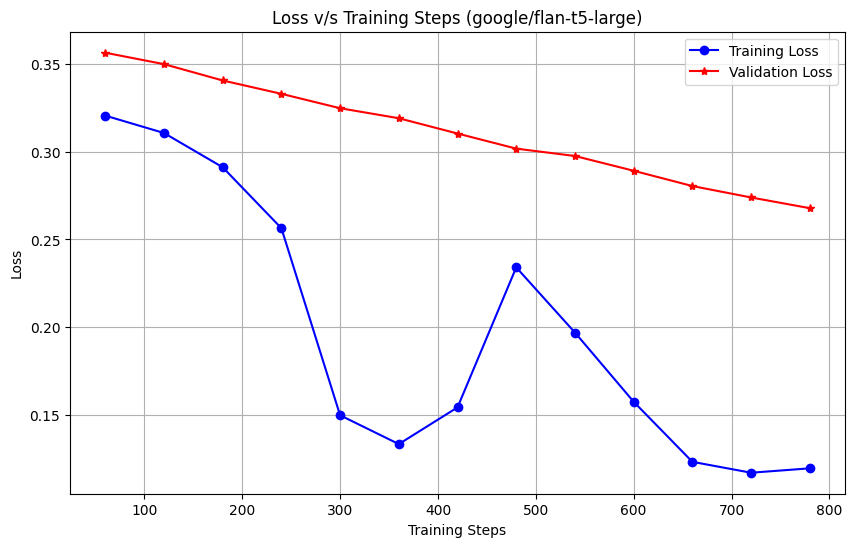

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

# Data from the previous cell's output
steps = [60, 120, 180, 240, 300, 360, 420, 480, 540, 600, 660, 720, 780]

training_loss = [0.3205, 0.3106, 0.2911, 0.2564, 0.1499, 0.1335,
                 0.1544, 0.2341, 0.1970, 0.1576, 0.1234, 0.1172, 0.1197]
validation_loss = [0.3563, 0.3498, 0.3405, 0.3329, 0.3247,
                   0.3190, 0.3103, 0.3017, 0.2975, 0.2891, 0.2804, 0.2739, 0.2678]

# Plot
plt.figure(figsize=(10, 6))
plt.plot(steps, training_loss, marker='o',
         linestyle='-', color='b', label='Training Loss')
plt.plot(steps, validation_loss, marker='*',
         linestyle='-', color='r', label='Validation Loss')
plt.title('Loss v/s Training Steps (google/flan-t5-large)')
plt.xlabel('Training Steps')
plt.ylabel('Loss')
plt.grid(True)
plt.legend()
plt.show()

### Save the model
The finetuned model is then saved for future improvements or deployment.

In [ ]:
save_dir = f'models/RCTI_flan_t5_large_{epochs}e_qa'
trainer.save_model(save_dir)
print("Saved model to:", save_dir)

### Load model for testing
This section loads the finetuned model for testing purposes.

In [8]:
save_dir = f'models/RCTI_flan_t5_large_{epochs}e_qa'
finetuned_model = AutoModelForSeq2SeqLM.from_pretrained(save_dir, local_files_only=True, device_map="cuda")

### Test the model
Testing how the model does when fed a question.

In [7]:
max_input_tokens = 1000
max_output_tokens = 100

data_dir = 'Data Pre-processing\\jsonlines_ds\\RCTI-Basic.jsonl'
finetuning_dataset = load_dataset('json', data_files=data_dir, split="train")

test_q = "Who are you?"
print("Test question:\n",test_q)

print("Model's answer: ")
inputs = tokenizer(test_q, return_tensors="pt", truncation=True, max_length=max_input_tokens).to("cuda")
tokens = finetuned_model.generate(**inputs, max_length=max_output_tokens)
print(tokenizer.decode(tokens[0], skip_special_tokens=True))

Test question:
Who are you?
Model's answer:
I'm R.C. Bot, your friendly assistant for all things related to Ranchhodlal Chotalal Technical Institute (R.C. Technical Institute). I'm here to provide you with information about our courses, admissions, campus facilities, events, and more. If you have any questions about R.C.T.I, feel free to ask!
